# **Applications of Stoner-Wohlfarth Curves for Isotropic Polycrystals**

It may be that we don't know the constants, $K_{1}$ and $K_{2}$ accurately - these are not trivial to measure. If we know $M_{0}$ and can measure the saturation field, $H_{sat}$, we can calculate SW_curves with different $\frac{K_{2}}{K_{1}}$ and see which fits best.

<br>

Here are the usual imports and functions from the previous two notebooks:

In [1]:
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rc('font', size=10)
plt.rc('figure', figsize=(6,4))

In [2]:
def SW_E(theta, theta0, H, M0, K1, K2):
    """
    Calculate the energy per unit volume resulting from the
    balance of the anisotropy energy and Zeeman energy, given
    the arguments.
    
    Args:
        theta = angle in degrees between the magnetisation and the applied field
        theta0 = angle in degrees between the easy axis and the applied field
        H = applied field in Oe
        M0 = spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 = second order anisotropy constant in erg/cm^3
        K2 = fourth order anisotropy constant in erg/cm^3
    
    Returns: 
        E = float, the energy per unit volume for the conditions given, unit: erg/cm^3.
    """
    t1 = K1*numpy.sin(numpy.deg2rad(theta-theta0))**2
    t2 = K2*numpy.sin(numpy.deg2rad(theta-theta0))**4
    t3 = M0*H*numpy.cos(numpy.deg2rad(theta))
    return t1+t2-t3

In [3]:
def getData_single(FR, M0, K1, K2, theta0):
    """
    For each value of the field in the field range (FR), find the minimum
    of the absolute value of the derivative of the energy equation with
    respect to the angle theta.
    
    Args:
        FR : array of applied field values in Oe
        theta0 = angle in degrees between the easy axis and the applied field
        M0 = spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 = second order anisotropy constant in erg/cm^3
        K2 = fourth order anisotropy constant in erg/cm^3
        
    Returns:
        D : a list of angles theta in degrees at which the derivative of the energy
            equation is zero for the field values defined in FR
    """
    D = []
    IG = theta0
    for H in FR:
        q = minimize(SW_E, IG, args=(theta0, H, M0, K1, K2), method="Nelder-Mead")
        D.append(q.x[0])
        IG = q.x[0]

        
    return D

In [4]:
def getData_multi(TR, FR, M0, K1, K2):
    """
    For each value of theta0 in the range of angles (TR), and 
    for each value of the field in the field range (FR), find the minimum
    of the absolute value of the derivative of the energy equation with
    respect to the angle theta.
    
    Args:
        TR : array of the cosines of the angles theta0
        FR : array of applied field values in Oe
        M0 : spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 : second order anisotropy constant in erg/cm^3
        K2 : fourth order anisotropy constant in erg/cm^3
        
    Returns:
        data_all : a dict whose keys are the angles theta0 in degrees and whose values
                   are a list of angles theta in degrees at which the derivative of the energy
                   equation is zero for the field values defined in FR
    """
    data_all = {}   
    for theta0 in numpy.rad2deg(numpy.arccos(TR)):
        D = getData_single(FR, M0, K1, K2, theta0)
        data_all[str(theta0)] = D
        
    return data_all

In [5]:
def getAvearageCurve(data_all):
    q = numpy.zeros((len(data_all.keys()),len(FR)))
    K = list(data_all.keys())
    for i in range(len(K)):
        q[i] = numpy.cos(numpy.deg2rad(data_all[K[i]]))

    q = numpy.mean(q,axis=0)
    
    return q

<br>

### Calculating $K_{1}$ and $K_{2}$ from $M_{0}$ and $H_{sat}$
The anisotropy field can be defined as:

$H_{sat} = \frac{2\cdot K_{1} + 4\cdot K_{2}}{M_{0}}$

We can define a constant $C = K_{1} + 2\cdot K_{2}$. 

When $K_{2} = 0$, $C = K_{1}$ and therefore we can take C to always be equal to $\frac{H_{sat}M_{0}}{2}$ and then find values of K1 and K2 which fit certain K2/K1 ratios.

In [6]:
def getK1K2_W(C, Krat):
    """
    For Krat i.e. K2/K1, get K1 and K2, with the
    condition that K1+2*K2 = C
    """
    K1 = C/(1+(2*Krat))
    K2 = (C-K1)/2

    return [K1,K2]

<br>

### Let's assume that we only know $M_{0}$ and $H_{sat}$...

In [7]:
# Values for the experimental dataset of an isotropic polycrystal
M0 = 855 # erg/Oecm^3 == kA/m
Hsat = 53900 # Oe

C = (Hsat*M0)/2

In [8]:
Krat = [0.0, 0.1, 0.2]

Ks = {}
for i in Krat:
    q = getK1K2_W(C, i)
    Ks[str(i)] = q

In [9]:
Ks

{'0.0': [23042250.0, 0.0],
 '0.1': [19201875.0, 1920187.5],
 '0.2': [16458750.000000002, 3291749.999999999]}

<br>

Having defined the values we need, we can now calculate average SW-curves for a polycrystal with different K2/K1 ratios:

In [10]:
# field range (start, stop, step) in Oe
FR = numpy.arange(0, 14.25e4, 2.5e3)

In [11]:
# cos(thetaH) range (start, stop, step)
TR = numpy.arange(0.0,1.01,0.02)

In [12]:
data_all = {}

for k in Ks.keys():
    data_all[k] = getData_multi(TR, FR, M0, Ks[k][0], Ks[k][1])

In [13]:
data_ave = {}
for k in Ks.keys():
    data_ave[k] = getAvearageCurve(data_all[k])

In [14]:
pc = numpy.loadtxt("resources/polycrystal_isotropic.txt")

Text(0, 0.5, 'M / kA/m')

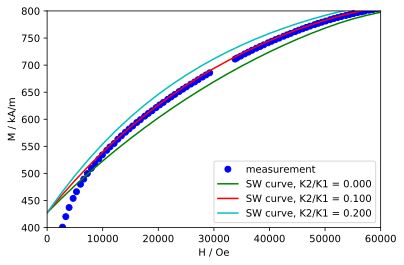

In [15]:
plt.plot(pc[:,0], pc[:,1],'bo', label="measurement")

colors = ["g", "r", "c"]
keys = list(Ks.keys())

for k in range(len(keys)):
    plt.plot(FR, data_ave[keys[k]]*M0, color=colors[k], ls='-', label="SW curve, K2/K1 = {:.3f}".format(float(keys[k])))

plt.xlim(xmin=0.0, xmax=60000)
plt.ylim(ymin=400, ymax=800)
plt.legend(loc="lower right")
plt.xlabel("H / Oe")
plt.ylabel("M / kA/m")

The SW-curve with K2/K1 = 0.1 fits best to the experimental data. This tells us that $K_{2} \neq0$ and that $K_{2} > 0$.

In [16]:
print("The values input are: K1 = {:.3e} erg/cm^3, K2 = {:.3e} erg/cm^3".format(Ks["0.1"][0], Ks["0.1"][1]))

The values input are: K1 = 1.920e+07 erg/cm^3, K2 = 1.920e+06 erg/cm^3


These compare well with the exact values for the experimental data, which we know from the previous notebook:

In [17]:
# Values for the experimental dataset of an isotropic polycrystal
M0 = 855 # erg/Oecm^3 == kA/m
K1 = 1.941e7 # erg/cm^3
K2 = 0.181e7 # erg/cm^3

The real value of K2/K1 is 0.093 (instead of 0.1) in this case.